<a href="https://colab.research.google.com/github/FerDoranNie/ColabNotebooks/blob/master/Technical_Assessment_Data_Scientist_Fernando_Dorantes_Nieto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entropy - Technical Assessment
For the position of Data Scientist.


## Objective
Build a model/algorithm that inputs a given budget and generates the daily ideal budget distribution across the paid media channels that maximizes sales given a user specified date that can be up to a month.

## Considerations
The provided datasets are paid media channels from an ecommerce store. You have to use the datasets to generate a model that maximizes the sales given X daily budget.

The dataset may include errors and outliers, make sure you clean up the data as you see fit.

## Bonus Points
I've added a datasets that includes conversion rate and sessions for the last ~5 years, this extends further the the media channel data, feel free to use it as the base for a seasonility model to further improve the predictions of the sales forecast predictions based on allocated budget. If using the seasonality data, you may of course, request a date for the budget recommendation and sales prediction so you can adjust results accordingly.

## Rules
* Assessment results has to be explained and commented in english.
* Please use Google Colab so I can easily review and run your work.
* Make sure your code executes correctly... Will disqualify candidates if code doesnt work.
* Its ok to take inspiration in others people (or AI) work, but please be ready to fully explain your thoughts behind your work. I prefer you use things you fully comprehend, instead of using foreign code & ideas that you dont fully understand.
* I will choose the best candidates based on my own judgement, but I will value explainability, creativity and elegance of the solution.

## Questions
Contact arturo@entropy.tech for any questions.

## Dataset
https://drive.google.com/file/d/17u9_ih3r3Q8q3N8uQ2Cy3AZdKdttHUg7/view?usp=sharing



# Assessment Data Scientist
Hello, I'm Fernando Dorantes Nieto.
Below you will see the code, the notes, the documentation and the references to be able to solve this test.

This notebook has different sections, to see them please click on the first icon on the left side.

## Installing necessary libraries and loading them

In [214]:
## What are the libraries that Colaboratory has installed?
from pkg_resources import working_set
#libraries = [x.project_name+' '+x.version for x in working_set]
libraries = [x.project_name for x in working_set]
required_libraries = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'plotnine',
                      'scikit-learn', 'scipy', 'datetime', 'pulp', 'cvxpy',
                      'plotly', 'PyDrive', 'math']
non_installed_libraries = [x for x in required_libraries if x not in libraries]

print('These libraries are not installed: \n' + '\n'.join('{}:{}'.format(*l)
  for l in enumerate(non_installed_libraries, start=1)))

These libraries are not installed: 
1:datetime
2:pulp
3:math


In [215]:
## Installing the extra libraries
! pip install datetime pulp

## Login to google drive ang getting data


In [216]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


The next code cell is necessary to run in order to get the data that we need.
Please run it and after of that a new window will appear and you must login with your google account, after of that you must copy the code and paste when it is required. (It is necessary sometimes if you logged before, the window does not appear).
The Google Drive files are public so any person can use them.

In [217]:
auth.authenticate_user()
googleAuth  = GoogleAuth()
googleAuth.credentials = GoogleCredentials.get_application_default()
drive= GoogleDrive(googleAuth)

The next code cells will allow you to get the necessary data

In [218]:
## Google Drive Links files
media1_IdDrive = '1Xw3muEzKVu-Etjp1LMgUFYwc9JMyMiP9'
media2_IdDrive = '1rHKWVB6kkhLusCnz88bv5yFVcE2oyPyx'
media3_IdDrive = '1ZEGtT5oaH2_PttHafVoM4gd106S5NS3e'
seasonality_IdDrive = '1EIJ3__FOADbqA9i1UHq1v8W6LmIQk0nk'

In [219]:
## Function to download the files from Drive to Colab
def downloadDrivefile(fileId, fileName):
  fileDownloaded = drive.CreateFile({'id': fileId})
  fileDownloaded.GetContentFile(fileName)


In [220]:
## Download the files
downloadDrivefile(fileId= media1_IdDrive, fileName='media1.csv')
downloadDrivefile(fileId= media2_IdDrive, fileName='media2.csv')
downloadDrivefile(fileId= media3_IdDrive, fileName='media3.csv')
downloadDrivefile(fileId= seasonality_IdDrive, fileName='seasonality.csv')


In [221]:
import pandas as pd
import numpy as np

In [222]:
## Function to load the datasets, add new column with a constant value and modify the date column
def loadData(filePath, delimiterFile, newColumnName,
             valueNewColumnName, colDate, formatDate):
  mainData = pd.read_csv(filePath, delimiter=delimiterFile)
  if colDate is not None:
    mainData[colDate] = pd.to_datetime(mainData[colDate], format= formatDate)
  if newColumnName is not None:
    mainData[newColumnName] = valueNewColumnName
    return mainData
  else:
    return mainData





In [223]:
## Loading all the datasets needed
media1Data = loadData(filePath= 'media1.csv', delimiterFile=',',
         newColumnName='media_origin', valueNewColumnName= 'media_1',
         colDate= 'date',
         formatDate= '%m/%d/%Y')

media2Data = loadData(filePath= 'media2.csv', delimiterFile=',',
         newColumnName='media_origin', valueNewColumnName= 'media_2',
         colDate= 'date',
         formatDate= '%m/%d/%Y')

media3Data = loadData(filePath= 'media3.csv', delimiterFile=',',
         newColumnName='media_origin', valueNewColumnName= 'media_3',
         colDate= 'date',
         formatDate= '%m/%d/%Y')

seasonalityData = loadData(filePath= 'seasonality.csv', delimiterFile=',',
         newColumnName=None, valueNewColumnName= None,
         colDate= 'date',
         formatDate= '%m/%d/%y')

mediaData  = pd.concat([media1Data, media2Data, media3Data])
print(mediaData.head())
print(seasonalityData.head())


        date    spend     sales media_origin
0 2022-09-01  95113.0  165879.0      media_1
1 2022-09-02  78221.0  455400.0      media_1
2 2022-09-03  78675.0  302078.0      media_1
3 2022-09-04  96216.0  477936.0      media_1
4 2022-09-05  89380.0  376129.0      media_1
        date  sessions  conversion_rate
0 2018-01-01      8713           0.0049
1 2018-01-02     12188           0.0051
2 2018-01-03     12119           0.0078
3 2018-01-04     12075           0.0055
4 2018-01-05     13694           0.0113


In [224]:
## Make sure that the data types are numeric
mediaData['spend'] = mediaData['spend'].astype(float)
mediaData['sales'] = mediaData['sales'].astype(float)
seasonalityData['sessions'] = seasonalityData['sessions'].astype(float)
seasonalityData['conversion_rate'] = seasonalityData['conversion_rate'].astype(float)



## Exploratory Analysis

### Cleaning data and detecting outliers


#### Detecting outliers

It is necesssary to check if we have outliers, because the outliers could be a problem when we need to create the model

In [225]:
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [226]:
## Function to plot values as an histogram and detect outliers
def plotHist(df, columns, titlesPlots):
  numPlots = len(columns)
  numRows = math.ceil(numPlots/2)
  ### Lets build the charts
  fig, ax = plt.subplots(numRows, 2, figsize= (10, 5))
  ax = ax.flatten()
  for i, column in enumerate(columns):
    ax[i].hist(df[column], bins='auto', color = '#7accc8')
    ax[i].set_title(titlesPlots[i])
  for x in range(numPlots, len(ax)):
    fig.delaxes(ax[x])
  fig.tight_layout()
  plt.show()

In [227]:
## Function to plot values as an boxplot and detect outliers
def plotBox(df, x, y, colorCol ):
  df = df.reset_index()
  if colorCol is not None:
    sns.boxplot(x = x, y= y, data= df, hue = colorCol)
  else:
    sns.boxplot(x = x, y= y, data= df)
  plt.show()

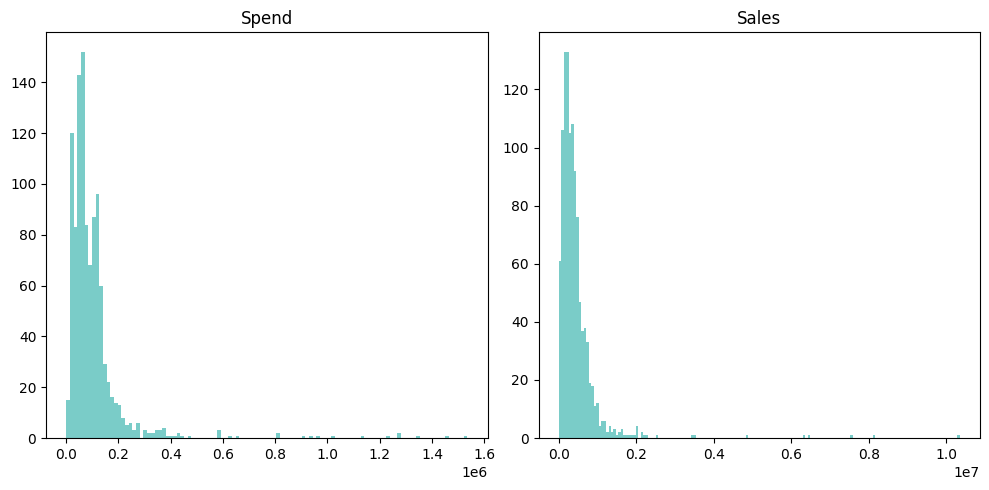

In [228]:
## Checkig all mediaData
plotHist(mediaData, columns = ['spend', 'sales'], titlesPlots=['Spend', 'Sales'])

In [229]:
#mediaList  = mediaData['media_origin'].unique()

#for m in mediaList:
#  filterData = mediaData[mediaData['media_origin']==m]
#  plotHist(filterData, columns = ['spend', 'sales'], titlesPlots=[ m+' Spend', m+' Sales'])

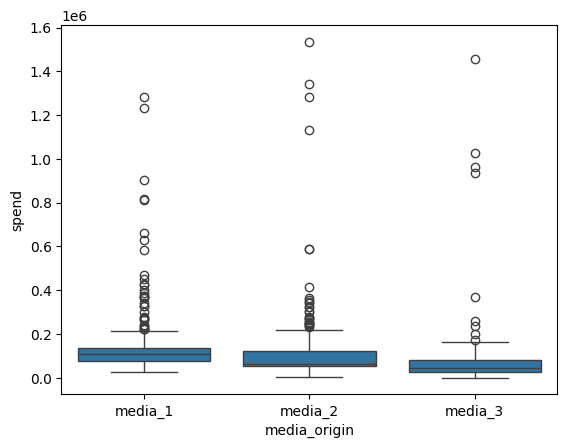

In [230]:
## It looks like that mediaData has outliers Im going to check the media origins
plotBox(df= mediaData, x='media_origin', y ='spend' , colorCol=None)

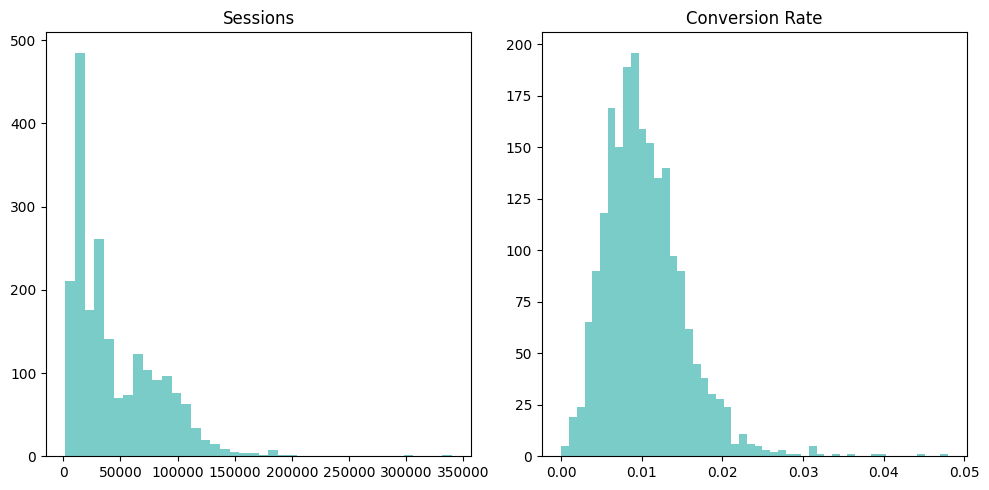

In [231]:
## Checking seasonality Data
plotHist(seasonalityData, columns = ['sessions', 'conversion_rate'], titlesPlots=['Sessions', 'Conversion Rate'])

It appears that all datasets have outliers, i will check if is related to time

In [232]:
def timePlotGrouped(df, groupedCol, dateCol, variableCol, xlab, ylab, title):
  data = df.groupby(groupedCol)
  fig, ax = plt.subplots(figsize=(10, 5))
  for key, group in data:
    ax.plot(group[dateCol], group[variableCol], label=key)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)
  ax.legend()
  ax.grid(True)
  plt.show()


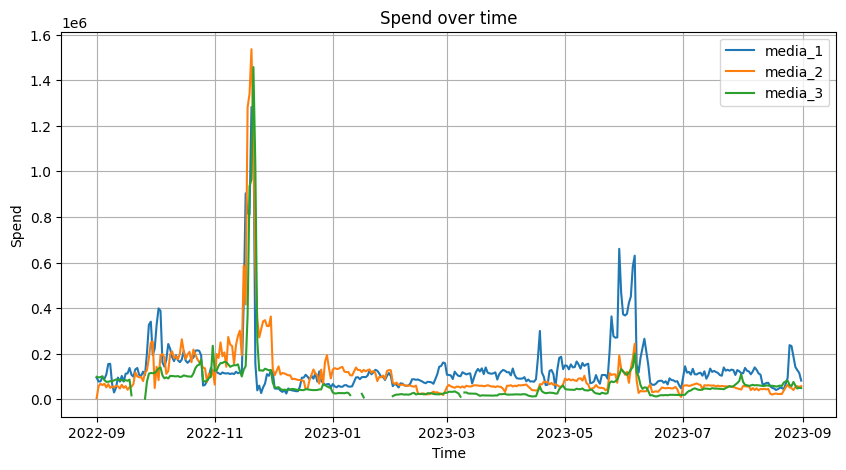

In [233]:
timePlotGrouped(df= mediaData, groupedCol='media_origin', dateCol='date',
                variableCol='spend', xlab='Time', ylab='Spend', title='Spend over time')

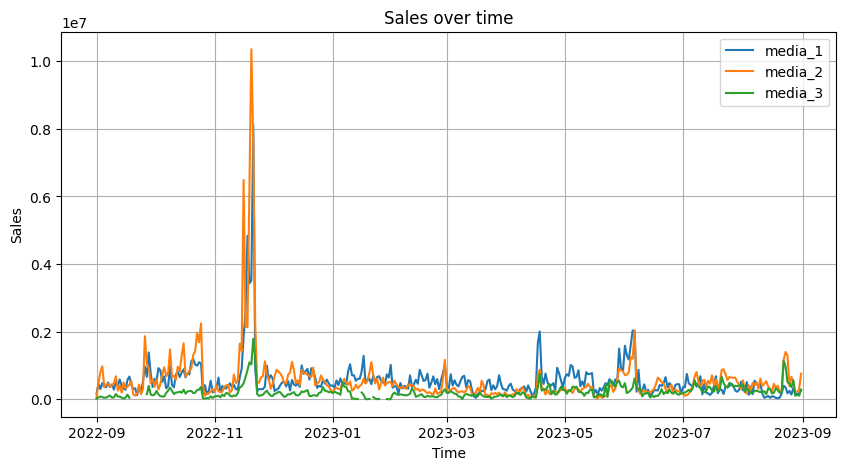

In [234]:
timePlotGrouped(df= mediaData, groupedCol='media_origin', dateCol='date',
                variableCol='sales', xlab='Time', ylab='Sales', title='Sales over time')

In [235]:
## What are the missing values?, let's check the values from maximun to minimum
mediaData.groupby('date').agg({'spend':'sum', 'sales': 'sum'}).sort_values(by='spend', ascending=False)


,spend,sales
date,,
2022-11-21,3820834.0,17481073.0
2022-11-20,3782325.0,14893014.0
2022-11-19,3085248.0,10859502.0
2022-11-18,2466398.0,7829815.0
2022-11-22,1769063.0,4356783.0
...,...,...
2023-02-18,114656.0,854203.0
2023-06-15,113384.0,516658.0
2023-06-16,110236.0,626672.0


It looks like that November was the monst successful month, but maybe it is an outlier, let´s check the another dataset if we can check that November is the most successful month

<Axes: xlabel='date', ylabel='sessions'>

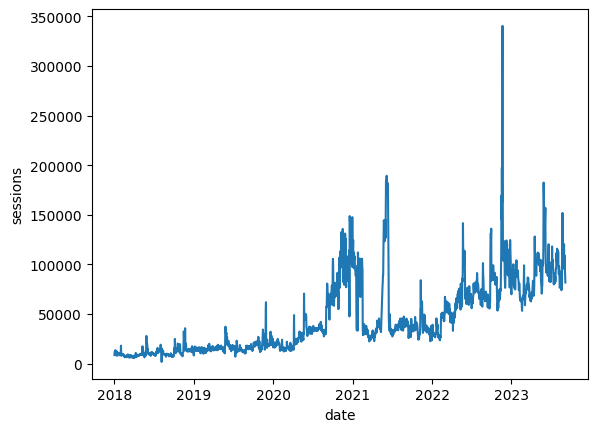

In [236]:
sns.lineplot(x='date', y='sessions', data=seasonalityData)

<Axes: xlabel='date', ylabel='conversion_rate'>

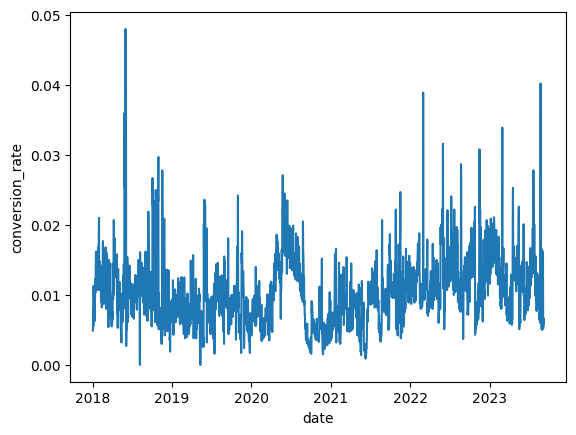

In [237]:
sns.lineplot(x='date', y='conversion_rate', data=seasonalityData)

In [238]:
#seasonalityData['date_month']= pd.to_datetime(seasonalityData['date']).dt.to_period('m')
seasonalityData['date_month'] = seasonalityData['date'].dt.month
seasonalityData['date_year']= pd.to_datetime(seasonalityData['date']).dt.to_period('Y')


In [239]:
'''
seasonalityData.pivot_table(
    values='sessions', index='date_year', columns='date_month',
    aggfunc='mean'
)
'''

"\nseasonalityData.pivot_table(\n    values='sessions', index='date_year', columns='date_month', \n    aggfunc='mean'\n)\n"

In [240]:
mediaDataGrouped = mediaData.groupby('date').agg({'spend': 'sum', 'sales':'sum'})

In [241]:
mediaDataGrouped = pd.merge(mediaDataGrouped, seasonalityData, on='date')

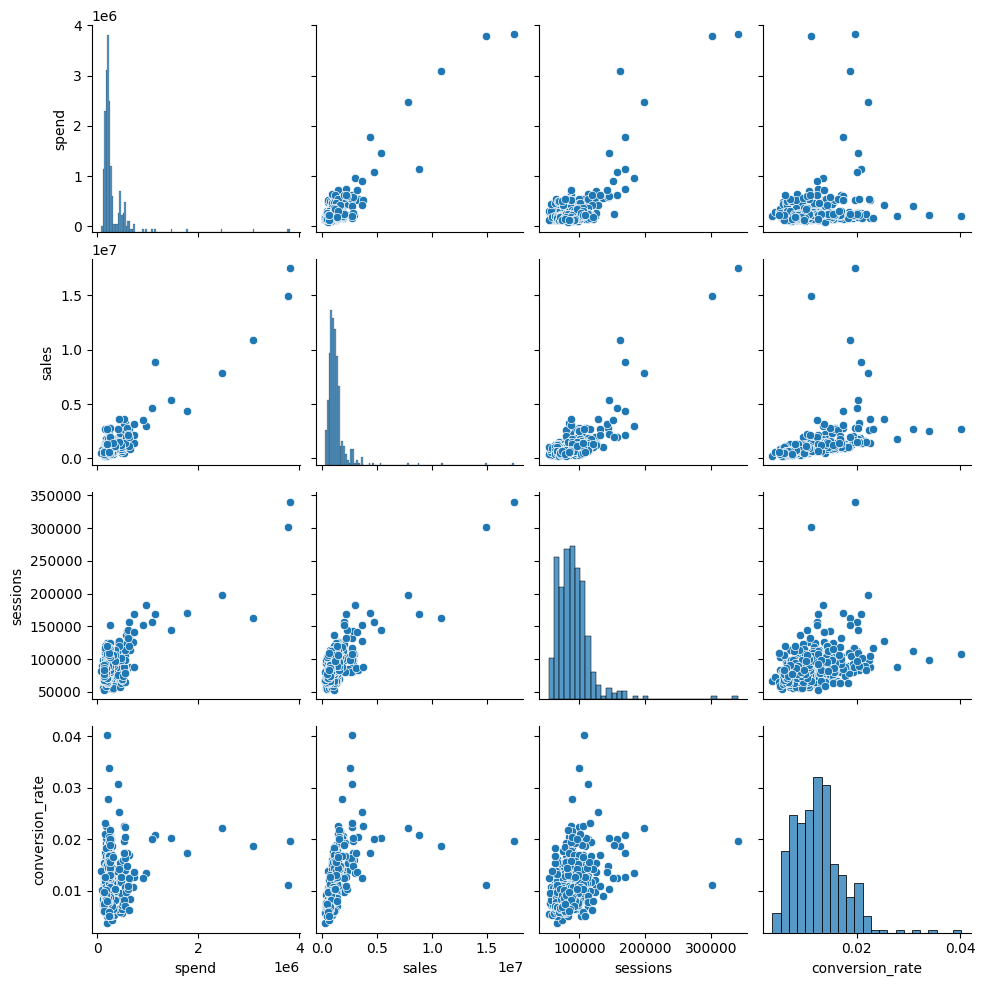

In [242]:
sns.pairplot(mediaDataGrouped, vars= ['spend', 'sales', 'sessions', 'conversion_rate'])
plt.show()

##### My opinion about the outliers


Looking at the values as such with an histogram or a boxplot, it seems that there are outliers ant it would be good to eliminate them with interquartile ranges.
However, when doing the pairplot I observe that there is an increase in spend and correlates with sessions and sales.
It seems that, although they are outliers, it would be wrong to eliminate them
Ir order to make the model, it would be better to add an extra column, that base on interquartile ranges, helps me to detect when the perios of maximum investment were.

In [243]:
## Function to create the column that detects the maximun dates of investment based on spend

def getLabelHighInvestmentPeriods(df, column, threshold=1.5):
  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)
  IQR = q3-q1
  # I need to create a maximun, that is the reason of this threshold
  highInvestmentThreshold = q3 + threshold * IQR
  df['high_investment'] = (df[column] > highInvestmentThreshold).astype(int)
  return df



In [244]:
mediaData=getLabelHighInvestmentPeriods(mediaData, column= 'spend')

In [245]:
mediaData = mediaData[['date', 'spend', 'sales', 'media_origin', 'high_investment']]

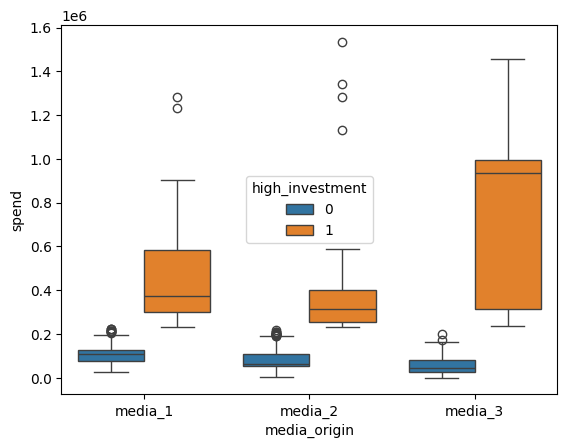

In [246]:
plotBox(df= mediaData, x='media_origin', y ='spend',colorCol='high_investment')

Ok, it looks like that the function works, now we need to check if there are missing data

#### Detecting missing data

Now that we detect the outliers and modify the dataset according the findings,
its necessary to detect if we have missing data

In [247]:
## Function to detect misssing data from grouped values
def detectMissingGrouped(df, groupedColumns):
  nullCounting = df.groupby(groupedColumns).agg(lambda column: column.isna().sum())
  return nullCounting

In [248]:
from google.colab import data_table
data_table.enable_dataframe_formatter()


In [249]:
detectMissingGrouped(df = mediaData, groupedColumns=['media_origin'])


,date,spend,sales,high_investment
media_origin,,,,
media_1,0,0,0,0
media_2,0,0,0,0
media_3,0,23,11,0


In [250]:
pd.DataFrame(seasonalityData.isna().sum())

,0
date,0
sessions,0
conversion_rate,0
date_month,0
date_year,0


##### Notes about missing data
In the dataset with name seasonalityData it has no problems with missing values.
The another dataset called mediaData does have missing values but only in one category, the category that I called "media_origin_3"
The missing values belongs to the columns called "sales" and "spend".
We have different methods to handling missing values.
Since simple methods like average or median, or techniques based on interpolation or even more complicated techniques like predictive models based on regressions


In this case I'm going to use the interpolation method


In [251]:
def interpolateColumn(df, columnToInterpolate, newcolumnName, interpolateMethod):
  df[newcolumnName] = df[columnToInterpolate].interpolate(method=interpolateMethod)
  return df

I'm going to test with the spend column and check the time series to check the missing values

For this i'm, going to create a new column with two values "was a missing value", 'no missing value' and compare in the chart, also in the average and median
If this is ok, I'm going to apply this technique to the original columns "sales" and "spend"

In [252]:
test= mediaData.copy()
test = interpolateColumn(test, columnToInterpolate='spend',
                              newcolumnName='spending_test', interpolateMethod='linear')


test['missing_category'] = np.where(test['spend'].isna(), 'was a missing value', 'no missing value')
test= test[test['media_origin']=='media_3']


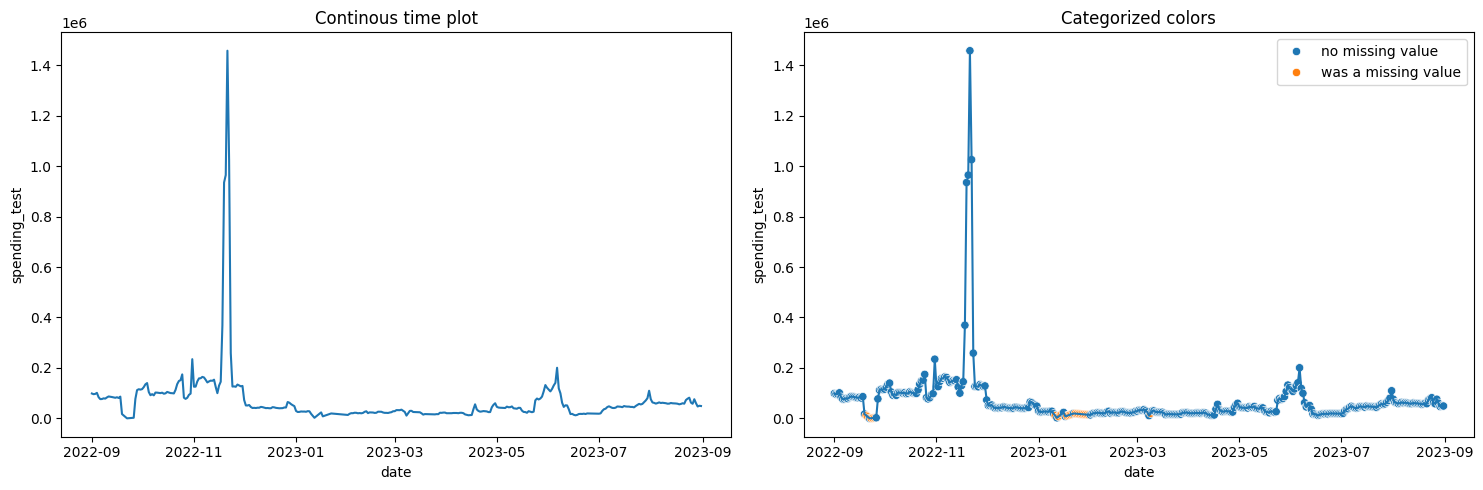

In [253]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot( x='date', y='spending_test', data=test, ax= axes[0]).set_title("Continous time plot")
sns.scatterplot(x='date', y='spending_test', hue='missing_category',
                data=test, ax=axes[1], alpha=1)
sns.lineplot( x='date', y='spending_test', data=test, ax= axes[1]).set_title("Categorized colors")
plt.tight_layout()
plt.show()


##### More notes about missing values


It seems that the interpolation method has worked, it is time to apply it to both columns.

In [254]:
mediaData = interpolateColumn(mediaData, columnToInterpolate='spend',
                              newcolumnName='spend', interpolateMethod='linear')

mediaData = interpolateColumn(mediaData, columnToInterpolate='sales',
                              newcolumnName='sales', interpolateMethod='linear')


In [257]:
mediaData.shape

(1095, 5)

In [259]:
mainData = pd.merge(mediaData, seasonalityData, on='date')
mainData.shape

(1095, 9)

In [261]:
mainData.columns

Index(['date', 'spend', 'sales', 'media_origin', 'high_investment', 'sessions',
       'conversion_rate', 'date_month', 'date_year'],
      dtype='object')

In [260]:
mainData.head()

,date,spend,sales,media_origin,high_investment,sessions,conversion_rate,date_month,date_year
0,2022-09-01,95113.0,165879.0,media_1,0,66029.0,0.0037,9,2022
1,2022-09-02,78221.0,455400.0,media_1,0,62894.0,0.0084,9,2022
2,2022-09-03,78675.0,302078.0,media_1,0,66438.0,0.0122,9,2022
3,2022-09-04,96216.0,477936.0,media_1,0,68924.0,0.0135,9,2022
4,2022-09-05,89380.0,376129.0,media_1,0,72636.0,0.0111,9,2022


## Building the model

## Testing the model

## Test the model with an interactive example

## References



1.   https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
2.   https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python
3.



